# 1 数据预处理

In [1]:
import torch 
from torch import Tensor 
from torch.utils.data import Dataset, DataLoader 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim 
from torchvision import transforms
from PIL import Image 
import csv 
import numpy as np 
from numpy import ndarray 
import math 
from typing import Any, Optional, Union, Callable
from tqdm.auto import tqdm 
import cv2 
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

## 1.1 对图像进行纹理特征提取

In [2]:
# LBP算法中范围半径的取值
radius = 1  

# 领域像素点数
n_points = 8 * radius  

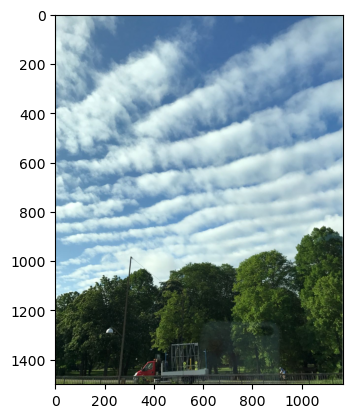

In [3]:
img = cv2.imread('./image/1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)

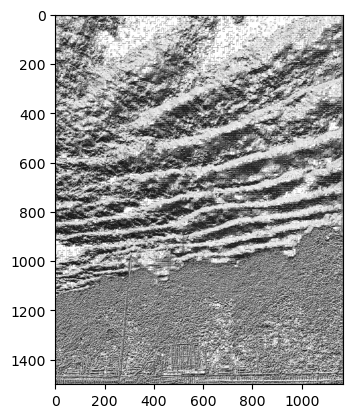

In [4]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_lbp = local_binary_pattern(img_gray, n_points, radius)

plt.imshow(img_lbp, 'gray')

## 1.2 对图像进行频域信息提取

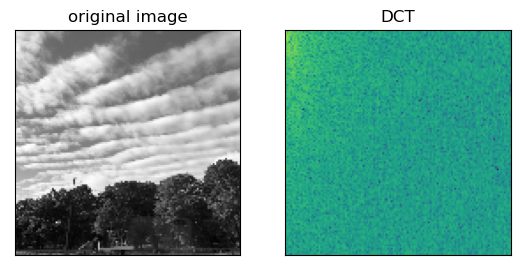

In [5]:
img = cv2.imread('./image/1.jpg', 0)
img = cv2.resize(img, (128, 128))
img_float = img.astype(np.float32)

# 离散余弦变换
img_dct = cv2.dct(img_float)

# log处理
img_dct_log = np.log(np.abs(img_dct))

# 离散余弦反变换
img_idct = cv2.idct(img_dct)

plt.subplot(121)
plt.imshow(img, 'gray')
plt.title('original image')
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.imshow(img_dct_log)
plt.title('DCT')
plt.xticks([])
plt.yticks([])

plt.show()

## 1.3 载入图像数据集

图像数据集分为三部分：
* 原始图片
* 经过纹理增强后的图片
* 经过频域变换后的图片

In [6]:
def load_train_dataset() -> ndarray:
    sample_list = [] 
    
    with open('./data/train.csv', 'r', encoding='utf-8') as fp:
        reader = csv.DictReader(fp)
        
        for row in reader:
            filename = row['FileName']

            path_1 = f'./data/image/{filename}'
            path_2 = f'./data/image_augmented_1/{filename}'
            path_3 = f'./data/image_augmented_1/{filename}'

            label = int(row['Code']) - 1
            
            sample = (path_1, path_2, path_3, label)
            sample_list.append(sample)

    sample_arr = np.array(sample_list, dtype=object)
    
    return sample_arr 


def load_test_dataset() -> ndarray:
    sample_list = [] 
    
    with open('./data/test.csv', 'r', encoding='utf-8') as fp:
        reader = csv.DictReader(fp)
        
        for row in reader:
            filename = row['FileName']
            
            path_1 = f'./data/image/{filename}'
            path_2 = f'./data/image_augmented_1/{filename}'
            path_3 = f'./data/image_augmented_1/{filename}'

            label = -1 
            
            sample = (path_1, path_2, path_3, label)
            sample_list.append(sample)

    sample_arr = np.array(sample_list, dtype=object)
    
    return sample_arr 

In [7]:
train_dataset = load_train_dataset()
train_dataset

array([['./data/image/fdad0045a3c845f89a3894975a1e9a87.jpg',
        './data/image_augmented_1/fdad0045a3c845f89a3894975a1e9a87.jpg',
        './data/image_augmented_1/fdad0045a3c845f89a3894975a1e9a87.jpg',
        9],
       ['./data/image/6e3f9856d6644c3fa6513734bb5c6145.png',
        './data/image_augmented_1/6e3f9856d6644c3fa6513734bb5c6145.png',
        './data/image_augmented_1/6e3f9856d6644c3fa6513734bb5c6145.png',
        18],
       ['./data/image/ac81ffdd29924e8f89abac01481b90b7.jpg',
        './data/image_augmented_1/ac81ffdd29924e8f89abac01481b90b7.jpg',
        './data/image_augmented_1/ac81ffdd29924e8f89abac01481b90b7.jpg',
        17],
       ...,
       ['./data/image/422e818c7ee24682be4713455616d2b5.jpg',
        './data/image_augmented_1/422e818c7ee24682be4713455616d2b5.jpg',
        './data/image_augmented_1/422e818c7ee24682be4713455616d2b5.jpg',
        24],
       ['./data/image/36f95c45ce0d41f3b01a6bfabab8ec4c.jpg',
        './data/image_augmented_1/36f95c45ce0d41

In [8]:
len(train_dataset)

8167

In [9]:
test_dataset = load_test_dataset()
test_dataset

array([['./data/image/85a2b5280cf44ee0bbedbc97ee45d2d5.jpg',
        './data/image_augmented_1/85a2b5280cf44ee0bbedbc97ee45d2d5.jpg',
        './data/image_augmented_1/85a2b5280cf44ee0bbedbc97ee45d2d5.jpg',
        -1],
       ['./data/image/f75f1e81924a43f2b6491035b6c7a491.jpg',
        './data/image_augmented_1/f75f1e81924a43f2b6491035b6c7a491.jpg',
        './data/image_augmented_1/f75f1e81924a43f2b6491035b6c7a491.jpg',
        -1],
       ['./data/image/aad9b2f79a9f46d4a343c3cface61871.jpg',
        './data/image_augmented_1/aad9b2f79a9f46d4a343c3cface61871.jpg',
        './data/image_augmented_1/aad9b2f79a9f46d4a343c3cface61871.jpg',
        -1],
       ...,
       ['./data/image/66c65624546f48d294da7618508c7831.jpg',
        './data/image_augmented_1/66c65624546f48d294da7618508c7831.jpg',
        './data/image_augmented_1/66c65624546f48d294da7618508c7831.jpg',
        -1],
       ['./data/image/54139ab75f1648fa935a6d5233ebf1fd.jpg',
        './data/image_augmented_1/54139ab75f164

In [10]:
len(test_dataset)

2043

## 1.4 划分训练集和验证集

In [11]:
def split_train_val_set(arr: np.ndarray, 
                        train_ratio: float,
                        val_ratio: float) -> tuple[np.ndarray, np.ndarray]:
    assert math.isclose(train_ratio + val_ratio, 1.) 
    N = len(arr) 
    perm = np.random.permutation(N)
    
    train_cnt = int(N * train_ratio)
    
    train_set = arr[perm[:train_cnt]]
    val_set = arr[perm[train_cnt:]]
    assert len(train_set) + len(val_set) == N  

    return train_set, val_set 


train_dataset, val_dataset = split_train_val_set(
    arr = train_dataset, 
    train_ratio = 0.8, 
    val_ratio = 0.2, 
)

train_dataset.shape, val_dataset.shape 

((6533, 4), (1634, 4))

## 1.5 载入DataLoader

In [12]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize([128, 128]),
    transforms.ToTensor(), 
])


class ImageDataset(Dataset):
    def __init__(self,
                 sample_arr: np.ndarray):
        super().__init__()
        
        self.sample_arr = sample_arr 
        
    def __getitem__(self, index: int) -> tuple[Tensor, Tensor, Tensor, int]:
        path_1, path_2, path_3, label = self.sample_arr[index]
        
        img_1 = cv2.imread(path_1, cv2.IMREAD_COLOR)
        img_1 = transform(img_1)
        
        img_2 = cv2.imread(path_2, cv2.IMREAD_COLOR)
        img_2 = transform(img_2)
        
        img_3 = cv2.imread(path_3, cv2.IMREAD_COLOR)
        img_3 = transform(img_3)
        
        return img_1, img_2, img_3, label 
    
    def __len__(self) -> int:
        return len(self.sample_arr)

In [13]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    dataset = ImageDataset(train_dataset),
    batch_size = BATCH_SIZE,
    shuffle = True,
    drop_last = False, 
)

val_dataloader = DataLoader(
    dataset = ImageDataset(val_dataset),
    batch_size = BATCH_SIZE,
    shuffle = False,
    drop_last = False, 
)

test_dataloader = DataLoader(
    dataset = ImageDataset(test_dataset),
    batch_size = BATCH_SIZE,
    shuffle = False,
    drop_last = False, 
)

len(train_dataloader), len(val_dataloader), len(test_dataloader)

(103, 26, 32)

# 2 模型

## 2.1 Xception

In [14]:
from cnn_finetune import make_model


class Xception(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = make_model(
            'xception', 
            num_classes = 2, 
            pretrained = True,
            input_size = (224, 224),
        )
        
        self.model._features[0] = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

        self.model = self.model._features[0:16]

    def forward(self, 
                batch: Tensor) -> Tensor:
        return self.model(batch)

## 2.2 Conv

In [15]:
class SingleConv(nn.Module):
    def __init__(self, 
                 in_channel: int, 
                 out_channel: int, 
                 norm: Optional[nn.Module] = None):
        super().__init__()
        
        self.in_channel = in_channel 
        self.out_channel = out_channel 

        if norm is None:
            norm = nn.BatchNorm2d(out_channel)

        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1),
            norm,
            nn.ReLU(),
        )

    def forward(self, 
                batch: Tensor) -> Tensor:
        batch_size, in_channel, height, width = batch.shape 
        assert in_channel == self.in_channel 
                
        out = self.conv(batch)
        assert out.shape == (batch_size, self.out_channel, height, width)
                
        return out 


class DoubleConv(nn.Module):
    def __init__(self,
                 in_channel: int, 
                 out_channel: int, 
                 norm: Optional[nn.Module] = None):
        super().__init__()
        
        self.in_channel = in_channel 
        self.out_channel = out_channel 

        self.conv = nn.Sequential(
            SingleConv(in_channel, out_channel, norm),
            SingleConv(out_channel, out_channel, norm),
        ) 

    def forward(self, 
                batch: Tensor) -> Tensor:
        batch_size, in_channel, height, width = batch.shape 
        assert in_channel == self.in_channel 
                
        out = self.conv(batch)
        assert out.shape == (batch_size, self.out_channel, height, width)
                
        return out 
    
    
ConvBlock3 = SingleConv 


class ConvBlock7(nn.Module):
    def __init__(self, 
                 in_channel: int, 
                 out_channel: int, 
                 norm: Optional[nn.Module] = None):
        super().__init__()
        
        self.in_channel = in_channel 
        self.out_channel = out_channel 

        if norm is None:
            norm = nn.BatchNorm2d(out_channel)

        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=7, stride=2, padding=3),
            norm,
            nn.ReLU(),
        )

    def forward(self, 
                batch: Tensor) -> Tensor:
        batch_size, in_channel, height, width = batch.shape 
        assert in_channel == self.in_channel 
                
        out = self.conv(batch)
        assert out.shape == (batch_size, self.out_channel, height // 2, width // 2)
                
        return out 
    
    
class ConvBlock6(nn.Module):
    def __init__(self, 
                 in_channel: int, 
                 out_channel: int, 
                 norm: Optional[nn.Module] = None):
        super().__init__()
        
        self.in_channel = in_channel 
        self.out_channel = out_channel 

        if norm is None:
            norm = nn.BatchNorm2d(out_channel)

        self.conv = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=5, stride=1, padding=2),
            norm,
            nn.ReLU(),
        )

    def forward(self, 
                batch: Tensor) -> Tensor:
        batch_size, in_channel, height, width = batch.shape 
        assert in_channel == self.in_channel 
                
        out = self.conv(batch)
        assert out.shape == (batch_size, self.out_channel, height, width)
                
        return out 


ConvBlock5 = ConvBlock6

## 2.3 Upsample

In [16]:
class Upsample(nn.Module):
    def __init__(self, 
                 in_channel: int, 
                 out_channel: int):
        super().__init__()
        
        self.in_channel = in_channel
        self.out_channel = out_channel
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv = DoubleConv(in_channel, out_channel)

    def forward(self, 
                batch: Tensor) -> Tensor:
        
        batch_size, in_channel, height, width = batch.shape 
        assert in_channel == self.in_channel 
        
        h = self.upsample(batch)
        assert h.shape == (batch_size, in_channel, height * 2, width * 2)
                
        out = self.conv(h)
        assert out.shape == (batch_size, self.out_channel, height * 2, width * 2)

        return out 

## 2.4 ViT

In [17]:
from einops import rearrange, repeat 
from self_attention_cv import TransformerEncoder


def expand_to_batch(tensor, desired_size):
    tile = desired_size // tensor.shape[0]
    return repeat(tensor, 'b ... -> (b tile) ...', tile=tile)


class ViT(nn.Module):
    def __init__(self, 
                 *,
                 img_dim,
                 in_channels = 3,
                 patch_dim = 16,
                 num_classes = 2,
                 dim = 512,
                 blocks = 6,
                 heads = 4,
                 dim_linear_block = 1024,
                 dim_head = None,
                 dropout = 0, 
                 transformer = None, 
                 classification = True):
        """
        Minimal re-implementation of ViT
        Args:
            img_dim: the spatial image size
            in_channels: number of img channels
            patch_dim: desired patch dim
            num_classes: classification task classes
            dim: the linear layer's dim to project the patches for MHSA
            blocks: number of transformer blocks
            heads: number of heads
            dim_linear_block: inner dim of the transformer linear block
            dim_head: dim head in case you want to define it. defaults to dim/heads
            dropout: for pos emb and transformer
            transformer: in case you want to provide another transformer implementation
            classification: creates an extra CLS token that we will index in the final classification layer
        """
        super().__init__()
        
        assert img_dim % patch_dim == 0, f'patch size {patch_dim} not divisible by img dim {img_dim}'
        self.p = patch_dim
        self.classification = classification

        # tokens = number of patches
        tokens = (img_dim // patch_dim) ** 2

        self.token_dim = in_channels * (patch_dim ** 2)
        self.dim = dim
        self.dim_head = (int(dim / heads)) if dim_head is None else dim_head

        # Projection and pos embeddings
        self.project_patches = nn.Linear(self.token_dim, dim)

        self.emb_dropout = nn.Dropout(dropout)

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_emb1D = nn.Parameter(torch.randn(tokens + 1, dim))
        self.mlp_head = nn.Linear(dim, num_classes)

        if transformer is None:
            self.transformer = TransformerEncoder(dim, blocks=blocks, heads=heads,
                                                  dim_head=self.dim_head,
                                                  dim_linear_block=dim_linear_block,
                                                  dropout=dropout)
        else:
            self.transformer = transformer

    def forward(self, img, mask=None):
        # Create patches
        # from [batch, channels, h, w] to [batch, tokens , N], N=p*p*c , tokens = h/p *w/p
        img_patches = rearrange(img,
                                'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                                patch_x=self.p, patch_y=self.p)

        batch_size, tokens, _ = img_patches.shape

        # project patches with linear layer + add pos emb
        img_patches = self.project_patches(img_patches)

        img_patches = torch.cat((expand_to_batch(self.cls_token, desired_size=batch_size), img_patches), dim=1)

        # add pos. embeddings. + dropout
        # indexing with the current batch's token length to support variable sequences
        img_patches = img_patches + self.pos_emb1D[:tokens + 1, :]
        patch_embeddings = self.emb_dropout(img_patches)

        # feed patch_embeddings and output of transformer. shape: [batch, tokens, dim]
        y = self.transformer(patch_embeddings, mask)

        # we index only the cls token for classification. nlp tricks :P
        return self.mlp_head(y[:, 0, :]) if self.classification else y[:, 1:, :]

## 2.5 Utrans

In [18]:
class Utrans(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()

        ch = 32
        filters = [ch, ch*2, ch*4, ch*8,ch*16,ch*32] #32,64,128,256,512,1024
        self.ori_1 = ConvBlock3(in_ch, filters[0]//2)#([1, 32, 128, 128])
        self.ori_2 = ConvBlock7(in_ch, filters[0])#([1, 32, 64, 64])

        self.chao_in = ConvBlock7(in_ch, filters[0])#([1, 32, 64, 64])
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.adapool= nn.AdaptiveAvgPool2d(1)
        self.conv2 = ConvBlock6(filters[1]+32, filters[1])
        self.conv3 = ConvBlock5(filters[1], filters[2])
        self.conv4 = ConvBlock3(filters[2], filters[2])
        self.conv5 = ConvBlock3(filters[2], filters[2])
        self.conv6 = ConvBlock3(filters[2], filters[3])

        self.conv7 = ConvBlock3(728,1024)
        
        self.fc1 = nn.Linear(512 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 2)

        self.img_dim_vit = 128 // 16 

        self.vit2 = ViT(img_dim=128,  # 8
                       in_channels=16,  # encoder channels  #1024
                       patch_dim=16,
                       dim=256,  # vit out channels for decoding  #1024
                       blocks=24 , # 12
                       heads=8,  # 4
                       dim_linear_block=256,  # 1024
                       classification=False)
        
        self.vit3 = ViT(img_dim=96,  # 8
                       in_channels=64,  # encoder channels  #1024
                       patch_dim=4,
                       dim=256,  # vit out channels for decoding  #1024
                       blocks=6 , # 12
                       heads=4,  # 4
                       dim_linear_block=256,  # 1024
                       classification=False)
        
        self.xception = Xception()
            
        self.classifier = nn.Sequential(  
            nn.Linear(1792, 28),
        )
        
    def forward(self, x1,x2,x3):
        ori_1= self.ori_1(x1)
        # print(ori_1.shape)
        ori_2 = self.ori_2(x2)
        # print(ori_2.shape)
        ori_p1=self.pooling(ori_2)

        chao_1=self.chao_in(x2)
        # print("chao_1",chao_1.shape)
        chao_p1 = self.pooling(chao_1)

        chao_2=self.chao_in(x3)
        # print("chao_21",chao_2.shape)
        chao_p2 = self.pooling(chao_2)

        ca1 = torch.cat((ori_p1, chao_p1,chao_p2), dim=1)
        conv2=self.conv2(ca1)
        p2=self.pooling(conv2)
        conv3 = self.conv3(p2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)
        p3 = self.pooling(conv5)
        conv6 = self.conv6(p3)
        
        # print("conv2",conv2.shape)
        y_2 = self.vit3(conv2) #32
        # print("y_2" ,y_2.shape)
        y_2= rearrange(y_2, 'b (x y) dim -> b dim x y ', x=self.img_dim_vit, y=self.img_dim_vit)
    
        ori= self.ori_1(x1)#128
        # print("oriori",ori.shape)
        y_1 = self.vit2(ori) 
        y_1= rearrange(y_1, 'b (x y) dim -> b dim x y ', x=self.img_dim_vit, y=self.img_dim_vit)

        ca1 = torch.cat([ conv6,y_1,y_2], dim=1)
        
        p=self.xception(x1)
        p =self.conv7(p)
        ca1 = torch.cat([p ,  ca1], dim=1)    
        ca1 =self.adapool(ca1)
        x = torch.flatten(ca1, start_dim=1)	# 展平后再传入全连接层
        x = self.classifier( x)
          
        return x

# 3 训练

In [19]:
DEVICE = 'cuda:7'
LR = 0.001
WEIGHT_DECAY = 0.001
NUM_EPOCHS = 1

In [20]:
device = torch.device(DEVICE)

model = Utrans().to(device)

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.99)

In [21]:
for epoch in tqdm(range(1, NUM_EPOCHS + 1), desc='Train Epoch'):
    model.train()
    
    loss_list: list[float] = []
    
    for step, (img_batch_1, img_batch_2, img_batch_3, label_batch) in enumerate(tqdm(train_dataloader, desc='Train Step'), start=1):
        img_batch_1 = img_batch_1.to(device)
        img_batch_2 = img_batch_2.to(device)
        img_batch_3 = img_batch_3.to(device)
        label_batch = label_batch.to(device)

        pred_batch = model(img_batch_1, img_batch_2, img_batch_3)

        loss = F.cross_entropy(input=pred_batch, target=label_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        loss_list.append(float(loss))
        
    print(f"[Train] Epoch: {epoch}, Loss: {np.mean(loss_list):.5f}")
        
    model.eval() 
    
    pred_list: list[ndarray] = []
    label_list: list[ndarray] = []
        
    for step, (img_batch_1, img_batch_2, img_batch_3, label_batch) in enumerate(tqdm(val_dataloader, desc='Val Step'), start=1):
        img_batch_1 = img_batch_1.to(device)
        img_batch_2 = img_batch_2.to(device)
        img_batch_3 = img_batch_3.to(device)
        label_batch = label_batch.to(device)

        with torch.no_grad():
            pred_batch = model(img_batch_1, img_batch_2, img_batch_3)
        
        pred_list.append(pred_batch.detach().cpu().numpy())
        label_list.append(label_batch.detach().cpu().numpy())

    pred_full = np.concatenate(pred_list, axis=0)
    label_full = np.concatenate(label_list, axis=0)
    pred_full = np.argmax(pred_full, axis=-1)
    
    val_acc = (pred_full == label_full).mean() 
    
    print(f"[Val] Epoch: {epoch}, Val Acc: {val_acc:.4f}")
    
    torch.save(model.state_dict(), f'./checkpoint/model_state_epoch_{epoch}.pt')

Train Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train Step:   0%|          | 0/103 [00:00<?, ?it/s]

[Train] Epoch: 1, Loss: 1.96786


Val Step:   0%|          | 0/26 [00:00<?, ?it/s]

[Val] Epoch: 1, Val Acc: 0.3599


# 4 测试

In [22]:
BEST_EPOCH = 1

model.load_state_dict(torch.load(f'./checkpoint/model_state_epoch_{epoch}.pt'))

model.eval() 
    
pred_list: list[ndarray] = []
    
for step, (img_batch_1, img_batch_2, img_batch_3, label_batch) in enumerate(tqdm(test_dataloader, desc='Test Step'), start=1):
    img_batch_1 = img_batch_1.to(device)
    img_batch_2 = img_batch_2.to(device)
    img_batch_3 = img_batch_3.to(device)

    with torch.no_grad():
        pred_batch = model(img_batch_1, img_batch_2, img_batch_3)
    
    pred_list.append(pred_batch.detach().cpu().numpy())

pred_full = np.concatenate(pred_list, axis=0)
pred_full = np.argmax(pred_full, axis=-1)
pred_full 

Test Step:   0%|          | 0/32 [00:00<?, ?it/s]

array([ 9,  9, 24, ...,  9, 26,  6])

In [23]:
test_filename_list: list[str] = [] 

with open('./data/test.csv', 'r', encoding='utf-8') as fp:
    reader = csv.DictReader(fp)
    
    for row in reader:
        filename = row['FileName']
        test_filename_list.append(filename)

In [24]:
assert len(pred_full) == len(test_filename_list)

with open('./data/submission.csv', 'w', encoding='utf-8') as fp:
    writer = csv.DictWriter(fp, fieldnames=['FileName', 'Code'])
    writer.writeheader()
    
    for pred, filename in zip(pred_full, test_filename_list):
        writer.writerow(
            dict(
                FileName = filename,
                Code = pred + 1,  
            )
        )